## Import

In [1]:
# Standard Python modules
import os, sys
import yaml
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc
# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

# Extra 
import wrf
from dask.distributed import Client

# import personal modules

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap, add_subregion_boxes, make_cmap
from timeseries import select_months_df, select_months_ds, combine_ar_ds_df
from statistical_tests import xr_zscore_diff_mean
from ar_funcs import HMA_subregions

In [2]:
import dask
dask.config.set(**{'array.slicing.split_large_chunks': False})

In [3]:
# Set up paths

path_to_data = '/home/nash/DATA/data/wrf_hasia/'          # project data on Great -- read only
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [4]:
# subregion info for ar type precip anomalies
domains = [HMA_subregions['Northwestern'], HMA_subregions['Western'], HMA_subregions['Eastern']]
region_name = ['NW', 'W', 'E']

# domain extent info 
# [xmin, ymin]
sr_xy = []
sr_width = []
sr_height = []

for i, d in enumerate(domains):
    sr_xy.append([d[0], d[2]])
    sr_width.append((d[1] - d[0]))
    sr_height.append((d[3]- d[2]))

print(sr_xy)
print(sr_width)
print(sr_height)

[[69, 37], [71, 32], [90, 24]]
[5, 8, 9]
[3, 5, 6]


In [5]:
start_date = '1979-12-01'
end_date = '2015-02-28'
mon_s = 12
mon_e = 2

df = pd.read_csv(path_to_out + 'DJF_ivt_ar_types_freezing_level_max_prec_20230317.csv')
df = df.drop(columns=['Unnamed: 0'])
df = df.set_index(pd.to_datetime(df['start_date']))
df.index = df.index.strftime("%Y-%m-%d")
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df

,trackID,ar_cat,start_date,end_date,duration,landslideID,landslide_lat,landslide_lon,ivt,ivtdir,freeze,prec
start_date,,,,,,,,,,,,
1979-12-02,2861.0,1.0,1979-12-02 00:00:00,1979-12-02 18:00:00,18.0,NaN,NaN,NaN,152.087860,224.91021331187994 degree,1.577197,13.718994
1979-12-01,2861.0,2.0,1979-12-01 00:00:00,1979-12-02 00:00:00,24.0,NaN,NaN,NaN,245.002441,220.23760859065467 degree,1.769546,17.533569
1979-12-09,2871.0,1.0,1979-12-09 06:00:00,1979-12-09 18:00:00,12.0,NaN,NaN,NaN,108.576300,231.68037841051355 degree,1.770839,5.676636
1979-12-08,2871.0,2.0,1979-12-08 06:00:00,1979-12-09 00:00:00,18.0,NaN,NaN,NaN,149.770879,237.0652245325259 degree,1.487703,8.985474
1979-12-16,2975.0,1.0,1979-12-16 12:00:00,1979-12-17 00:00:00,12.0,NaN,NaN,NaN,69.228194,270.4320425315212 degree,-0.055954,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31,114196.0,3.0,2014-12-31 18:00:00,2015-01-03 12:00:00,66.0,NaN,NaN,NaN,340.884138,240.43672607892813 degree,1.336010,4.890137
2015-01-03,114217.0,3.0,2015-01-03 18:00:00,2015-01-04 00:00:00,6.0,NaN,NaN,NaN,375.217412,250.3772879757895 degree,0.877406,4.515137
2015-01-21,114363.0,3.0,2015-01-21 06:00:00,2015-01-22 06:00:00,24.0,NaN,NaN,NaN,61.715181,188.15285286031184 degree,0.507094,NaN


## WRF 6.7km IVT, geopotential, and precipitation

In [6]:
%%time
start_yr = 1979
end_yr = 2015

domains = ['d02']
varname_lst = ['sr']

# get list of dates that ar is present
ar_dates = pd.to_datetime(df.index).values

## loop through each ds
ds_lst = []
for i, (dom, varname) in enumerate(zip(domains, varname_lst)):
    filename_pattern = path_to_data + '{0}/{1}/daily/out.wrf6km.{1}.daily_*.nc'.format(dom, varname)
    ds = xr.open_mfdataset(filename_pattern)
    
    # subset freezing level to just ar days
    ds = ds.sel(time = ar_dates)
    
    # Combine AR Cat and freeze data w/ WRF data
    colnames = ['ar_cat', 'freeze']
    for i, col in enumerate(colnames):
        ds[col] = ('time', df[col])
        ds = ds.set_coords(col)
        
    if varname == 'prec':
        ## calculate liquid water (rain = total prec - snow)
        ds = ds.assign(rain=lambda ds: (ds['prec'] - ds['snow']))
    
    ds_lst.append(ds)
    
ds_lst[0]

CPU times: user 518 ms, sys: 69.3 ms, total: 587 ms
Wall time: 653 ms


<xarray.Dataset>
Dimensions:  (time: 988, lat: 312, lon: 447)
Coordinates:
  * time     (time) datetime64[ns] 1979-12-02 1979-12-01 ... 2015-02-27
  * lat      (lat) float32 22.05 22.11 22.18 22.24 ... 40.17 40.23 40.28 40.33
  * lon      (lon) float32 68.24 68.31 68.37 68.44 ... 98.91 98.98 99.05 99.12
    ar_cat   (time) float64 1.0 2.0 1.0 2.0 1.0 3.0 ... 3.0 3.0 3.0 3.0 3.0 3.0
    freeze   (time) float64 1.577 1.77 1.771 1.488 ... 0.5071 -0.2528 0.3687
Data variables:
    sr       (time, lat, lon) float32 dask.array<chunksize=(13, 312, 447), meta=np.ndarray>

In [7]:
ds_lst[0].sr.sel(time='2010-02-06')[0]

<xarray.DataArray 'sr' (lat: 312, lon: 447)>
dask.array<getitem, shape=(312, 447), dtype=float32, chunksize=(312, 447), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 2010-02-06
  * lat      (lat) float32 22.05 22.11 22.18 22.24 ... 40.17 40.23 40.28 40.33
  * lon      (lon) float32 68.24 68.31 68.37 68.44 ... 98.91 98.98 99.05 99.12
    ar_cat   float64 1.0
    freeze   float64 0.2093

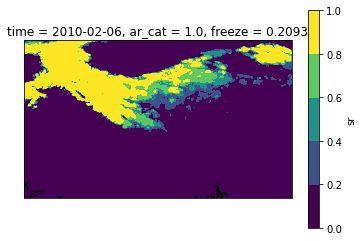

In [8]:
## test plot 1 time step of daily data
ax = plt.axes(projection=ccrs.PlateCarree())

ds_lst[0].sr.sel(time='2010-02-06')[0].plot.contourf(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

### Calculate Composite Differences

In [9]:
%%time
ds = ds_lst[0]
# Compare conditions (e.g. Type 1 ARs during high freezing vs. low freezing conditions) 
artype_lst = [2, 1, 3] # reorder to Northwestern, Western, and Eastern
freeze_thres = 0
com_diff = []
com_pval = []

for i, ar_type in enumerate(artype_lst):
    print('Calculating difference for AR Type:', ar_type)
    
    ## get the average fre
    idx = (ds['freeze'] > freeze_thres) & (ds['ar_cat'] == ar_type)
    data1 = ds.sel(time=idx)
    # print(data1)

    idx = (ds['freeze'] < freeze_thres) & (ds['ar_cat'] == ar_type)
    data2 = ds.sel(time=idx)
    # print(data2)
    # subtract above-average freezing level from below-average freezing level 
    diff, pval = xr_zscore_diff_mean(data1, data2)

    com_diff.append(diff.compute())
    com_pval.append(pval.compute())
        

Calculating difference for AR Type: 2


/home/sbarc/students/nash/miniconda3/envs/hasia2/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Calculating difference for AR Type: 1


/home/sbarc/students/nash/miniconda3/envs/hasia2/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Calculating difference for AR Type: 3


/home/sbarc/students/nash/miniconda3/envs/hasia2/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 24.6 s, sys: 1min 16s, total: 1min 41s
Wall time: 1min 12s


### Plot Difference Composites

In [10]:
# get terrain height from one wrf file
wrf_filename = "/home/hasia/2009/wrfout_d01_2010-02-04_03:00:00"
wrfin = nc.Dataset(wrf_filename)
ter = wrf.getvar(wrfin, 'ter', timeidx=0) # get terrain height

In [11]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# Set projections
datacrs = ccrs.PlateCarree()   # data/source
mapcrs = ccrs.PlateCarree()    # map/destination

# plot extents
lonmin = 69.
lonmax = 99.
latmin = 23.
latmax = 40.

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+10,10)
dy = np.arange(latmin,latmax+5,5)

# hack for tick labels
share_right = [False, False, True]*4
share_bottom = [False]*9 + [True]*3


-0.4131397 0.05212508
-0.34557545 0.15120766
-0.49338853 0.13765097


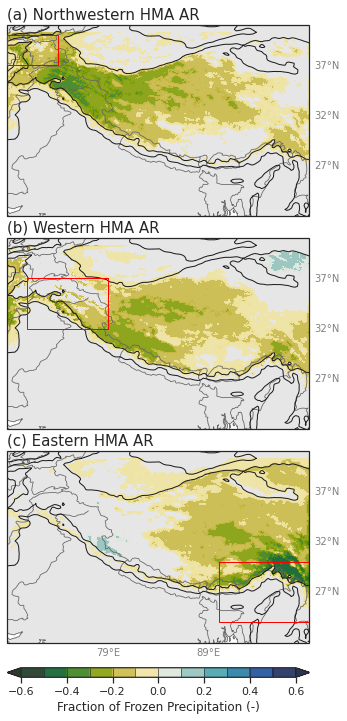

In [12]:
plt_lbl = ['(a) Northwestern HMA AR', '(b) Western HMA AR', '(c) Eastern HMA AR']
# ar_idx = [3, 1, 8]
sr_idx = [0, 1, 2]

share_bottom=[False, False, True]

filepath = path_to_figs + 'freezing_sr_diff_composite_portrait.png'
nrows = 3
ncols = 1
sig_level = 0.05 # significance level for testing

# Create figure
fig = plt.figure(figsize=(10, 12))

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.3,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.05, cbar_size='5%',label_mode='',
                direction='row')

for k, ax in enumerate(axgr):
    data = com_diff[k]
    pval = com_pval[k]

    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values    
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy,
                      left_lats=False, right_lats=True, bottom_lons=share_bottom[k])
    
    # Contour Filled
    ratio = data.sr.values
    print(np.nanmin(ratio), np.nanmax(ratio))
    ratio_mask = data.sr.where((pval.sr <= sig_level)).values
    # print(np.nanmin(ratio[ratio != -np.inf]), np.nanmax(ratio[ratio != np.inf]))
    cflevs = np.arange(-0.6, 0.7, 0.1)
    # newcmap = cmocean.tools.crop_by_percent(cmo.ice, 30, which='min', N=None)
    cf = ax.contourf(lons, lats, ratio_mask, transform=datacrs,
                     levels=cflevs, cmap=cmo.delta_r, alpha=0.9, extend='both')
    
    # Contour Lines (terrain)
    clevs=np.array([1000, 3000])
    cs = ax.contour(ter.XLONG, ter.XLAT, ter.values, clevs, colors='k', linewidths=1.0,
                    linestyles='solid', transform=datacrs)
    
    
    # subtitles
    ax.set_title(plt_lbl[k], loc='left',fontsize=15)
    
    # add subregions
    m = sr_idx[k]
    add_subregion_boxes(ax=ax, subregion_xy=[sr_xy[m]], width=[sr_width[m]], 
                        height=[sr_height[m]], ecolor='red', datacrs=datacrs)
    
    
    
# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('Fraction of Frozen Precipitation (-)')
    
# Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()
